In [1]:
from os.path import exists 
import pandas as pd
import shap
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC

from utils.data_preparation import *
from utils.data_exploration import *
from utils.training import *


task = "cyp2d6"

In [2]:
pd.read_csv(f"optimization/{task}/best.csv", comment="#").sort_values("val_mcc", ascending=False)

,model,val_accuracy,val_f1,val_mcc,false_negative_rate,false_positive_rate
12,XGBoost_3,0.90,0.71,0.66,0.35,0.041
6,XGBoost_2,0.89,0.70,0.64,0.35,0.049
0,SVC,0.88,0.70,0.63,0.29,0.077
4,CatBoost,0.89,0.64,0.61,0.49,0.020
7,XGBoost_2_threshold_0.3,0.87,0.68,0.61,0.27,0.093
8,XGBoost_1,0.89,0.67,0.61,0.41,0.043
11,XGBoost_0_threshold_0.23,0.88,0.68,0.61,0.31,0.075
1,RandomForest,0.89,0.63,0.60,0.51,0.019
10,XGBoost_0,0.89,0.62,0.59,0.51,0.020
9,XGBoost_1_threshold_0.28,0.84,0.65,0.57,0.22,0.140


# Data

In [3]:
# load thedataset
data = data_preprocessing(task)

# we only use Morgan fingerprints
data = data.drop(["MACCS_FP", "ATOMPAIR_FP"], axis=1)

# druglike molecules
data = select_druglike_molecules(data)

# turn string of fingerprints into single features
morgan_fingerprint_df = pd.DataFrame(
    convert_strings_to_int_array(data["Morgan_FP"].values), index=data.index
)
data = data.merge(morgan_fingerprint_df, left_index=True, right_index=True)

# remove NaN values
data_nan = extract_null(data)
data = data.drop(data_nan.index)

display(data)

# split data in train, val, test
datasets = dataset_split(data.drop(["Drug", "Drug_ID", "Morgan_FP"], axis=1))
# The descriptors include discrete and continuous data, distinguished by their dtype.
feature_groups = get_feature_groups(datasets, morgan_fingerprint_df)

Dataset already exists, returning data/cyp2d6/raw_dataset.csv.
Number of molecules before druglikeliness selection: 13130
Number of druglike molecules: 12662


,Y,Drug,Drug_ID,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,CCN1C(=O)/C(=C2\SC(=S)N(CCCOC)C2=O)c2ccccc21,1960010.0,12.820479,-0.183140,12.820479,0.128619,0.457873,362.476,344.332,...,0,0,0,0,0,0,1,0,0,0
1,0,CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1,644675.0,12.610408,-3.973681,12.610408,0.072387,0.720977,355.418,346.346,...,0,0,0,0,0,0,0,0,0,0
2,1,COc1ccccc1C(c1nnnn1C(C)(C)C)N1CCN(Cc2ccncc2)CC1,644890.0,5.719940,-0.219974,5.719940,0.075509,0.605920,421.549,390.301,...,0,0,0,0,0,0,0,0,0,0
3,0,CC(=O)Nc1cccc(NC(=O)C2CCCN2C(=O)Nc2ccccc2C)c1,645063.0,12.762343,-0.533851,12.762343,0.182110,0.757037,380.448,356.256,...,0,0,0,0,0,0,0,0,0,0
4,0,CCC(c1nnnn1CC1CCCO1)N(CCN1CCOCC1)Cc1cc2cc(C)cc...,645164.0,13.082813,-0.044883,13.082813,0.018472,0.457249,495.628,458.332,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13125,0,C=CC1=C[C@@H](O)[C@@H]2O[C@@H]2C12OCCCO2,16758815.0,9.674588,-0.801690,9.674588,0.174259,0.635371,210.229,196.117,...,0,0,0,0,0,0,0,0,0,0
13126,0,O=C1[C@H]2CC=C3[C@@H]([C@H](O)[C@H]4O[C@@H]4C3...,16758816.0,13.390757,-1.019880,13.390757,0.162294,0.455270,397.427,374.243,...,0,0,0,0,0,0,0,0,0,0
13127,0,CCN1C(=O)[C@H]2CC=C3[C@@H]([C@H](O)[C@H]4O[C@@...,16758817.0,12.817440,-0.985371,12.817440,0.131139,0.406549,335.356,314.188,...,0,0,0,0,0,0,0,0,0,0
13128,0,C[C@H](c1ccccc1)N1C(=O)[C@@H]2[C@@H](CC[C@@H]3...,16758818.0,13.179767,-1.161112,13.179767,0.077392,0.772281,357.406,334.222,...,0,0,0,0,0,0,0,0,0,0


Splitting the data into 70.00% training, 10.00% validation, and 20.00% testing.
Unique Datatypes: {dtype('int64'), dtype('float64')}


# XGBoost

In [4]:
file_loc = f"optimization/{task}/xgboost_3.csv"

# print comments
comments = ""
with open(file_loc, "r") as f:
    for line in f:
        if line[0] == "#":
            comments+=line

print(comments)

# print hyperparameter optimization results
pd.read_csv(file_loc, comment="#").drop("Unnamed: 0", axis=1).sort_values("val_mcc", ascending=False).head()

# fix_model_params={'objective': 'binary:logistic', 'eval_metric': 'aucpr'}
# main_metric=mcc
# model_params=[Integer(low=5, high=50, prior='uniform', transform='identity'), Real(low=0.01, high=0.2, prior='uniform', transform='identity'), Real(low=0.5, high=1, prior='uniform', transform='identity'), Real(low=3.140197789412449, high=10, prior='uniform', transform='identity'), Real(low=0.5, high=1.0, prior='uniform', transform='identity'), Real(low=0.5, high=4.0, prior='uniform', transform='identity')]
# preprocessing_params=None



,max_depth,eta,subsample,scale_pos_weight,colsample_bytree,lambda,var_threshold_continuous,var_threshold_discrete,var_threshold_fingerprint,corr_threshold,val_accuracy,val_f1,val_precision,val_recall,val_mcc,val_roc_auc_score,val_average_precision_score
43,17,0.118477,0.916149,8.247307,0.973521,3.311597,0.001642,0.003208,0.012549,0.985838,0.900951,0.711316,0.785714,0.649789,0.656468,0.903489,0.765802
37,14,0.131821,0.926805,9.500499,0.705297,2.367464,0.005784,0.011021,0.014793,0.980531,0.897781,0.706150,0.767327,0.654008,0.647771,0.894729,0.758034
26,33,0.172853,0.897724,7.962732,0.950023,2.517450,0.003638,0.013105,0.042575,0.979696,0.897781,0.699301,0.781250,0.632911,0.643677,0.894239,0.754599
45,15,0.127570,0.887050,8.723899,0.590065,2.422075,0.002453,0.012648,0.015474,0.942037,0.895404,0.695853,0.766497,0.637131,0.637287,0.898080,0.751380
9,28,0.176870,0.966745,6.485500,0.749516,2.739529,0.017325,0.009691,0.036783,0.987504,0.896989,0.687500,0.798883,0.603376,0.636118,0.899881,0.760310


In [5]:
model = XGBClassifier(
    max_depth=17,
    eta=0.118477,
    subsample=0.916149,
    scale_pos_weight=8.247307,
    colsample_bytree=0.973521,
    reg_lambda=3.311597,
    objective="binary:logistic",
    eval_metric="aucpr",
)

data_prep = DataPreprocessing(
    feature_groups,
    var_threshold={
        "continuous": 0.001642,
        "discrete": 0.003208,
        "fingerprint": 0.012549,
    },
    corr_threshold=0.985838,
)


data_prep.fit(datasets["train"].drop("Y", axis=1), datasets["train"]["Y"])
x_train_prep = data_prep.transform(datasets["train"].drop("Y", axis=1))
x_val_prep = data_prep.transform(datasets["val"].drop("Y", axis=1))
x_test_prep = data_prep.transform(datasets["test"].drop("Y", axis=1))

model.fit(x_train_prep, datasets["train"]["Y"])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.973521, early_stopping_rounds=None,
              enable_categorical=False, eta=0.118477, eval_metric='aucpr',
              gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.118477002,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=17,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, ...)

Accuracy: 90.10%
F1-score: 71.13%
Matthews correlation coefficient: 0.6564681867411861%


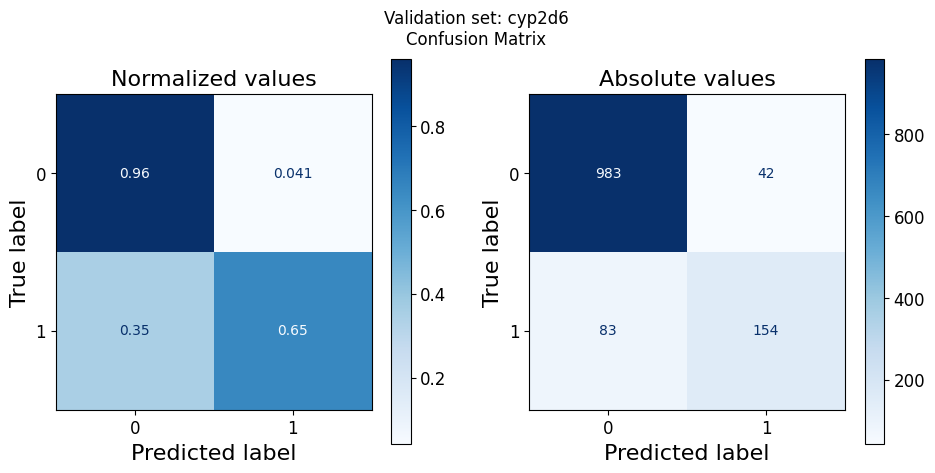

Accuracy: 87.41%
F1-score: 65.13%
Matthews correlation coefficient: 0.57720801636912%


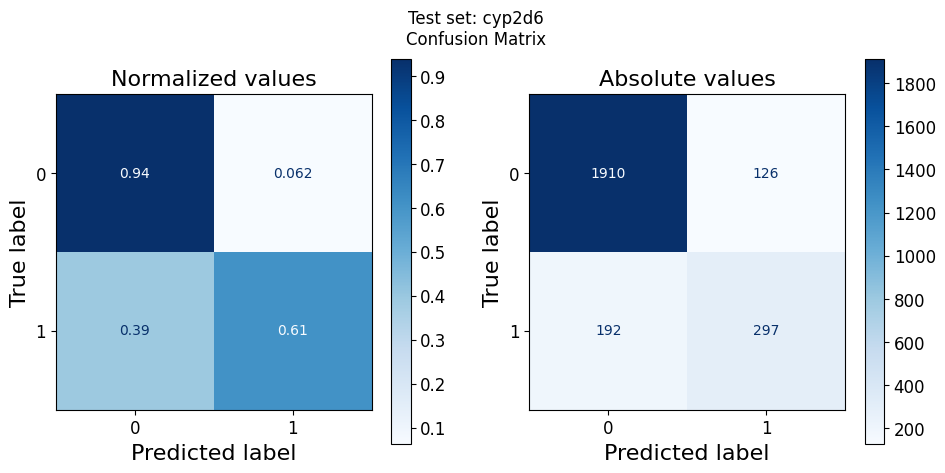

In [6]:
y_val_pred = model.predict(x_val_prep)
conf_matrix(datasets["val"]["Y"], y_val_pred, f"Validation set: {task}")

y_test_pred = model.predict(x_test_prep)
conf_matrix(datasets["test"]["Y"], y_test_pred, f"Test set: {task}")

## SHAP

In [7]:
# Add feature names to x_train_prep

data_norm = MinMaxScaler().fit_transform(datasets["train"].drop("Y", axis=1))
d1 = pd.DataFrame(data_norm, columns=datasets["train"].drop("Y", axis=1).columns)

d2 = pd.DataFrame(x_train_prep)
df = pd.concat([d2, d1], axis=1).T
x_train_prep_shap = df[df.duplicated()].T
model.fit(x_train_prep_shap, datasets["train"]["Y"])

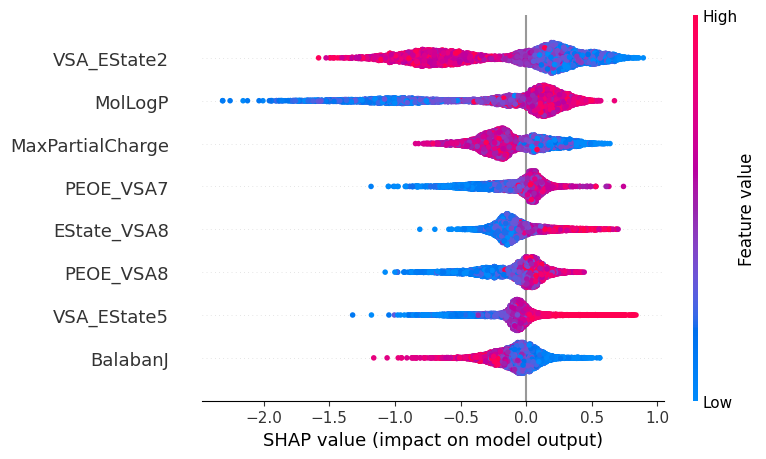

In [9]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train_prep_shap)
shap.summary_plot(shap_values, x_train_prep_shap, max_display=8)